In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import copy

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss

from sklearn.metrics import r2_score

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [30]:
path = '../DATA'

trainFile = 'train_augmented_engineered.csv'
testFile = 'test_augmented_engineered.csv'

In [31]:
# Load all data
train_df = pd.read_csv(os.path.join(path, trainFile),
                       header = 0,
                       index_col='id')
test_df = pd.read_csv(os.path.join(path, testFile),
                      header = 0,
                      index_col='id')


## Data imputation

#### This shouldnt be necessary as most gradient boosting libraries take care of nans

## Set data types

In [32]:
catCols = ['educationCat', 'marital', 'race', 'region', 'urban']
train_df[catCols] = train_df[catCols].astype('category')
test_df[catCols] = test_df[catCols].astype('category')

numericalCols = ['AnnualExpenditureByAge', 'AnnualExpenditureByAge_per_familysize',
                     'AnnualExpenditureByFamilySize',
                     'AnnualExpenditureByFamilySize_per_education', 'AnnualExpenditureByIncome',
                     'CPIUrban', 'CPIUrban_times_familySize', 'LaborForceParticip',
                     'UnemploymentRateByAge', 'age', 'age_per_familySize', 'education',
                     'education_per_familySize', 'education_per_income', 'familysize', 'income',
                     'month_c', 'month_s', 'occupation_mean', 'occupation_q1', 'occupation_q2',
                     'occupation_q3', 'occupation_q4', 'occupation_q5', 'state_mean', 'state_q1',
                     'state_q2', 'state_q3', 'state_q4', 'state_q5', 'year']
test_df[numericalCols] = test_df[numericalCols].astype('float')
test_df[numericalCols] = test_df[numericalCols].astype('float')
numericalCols.append('wi')
train_df[numericalCols] = train_df[numericalCols].astype('float')

## Scale numerical variables

Not using linear boosting, so no need to scale features.

## Try gradient boosting with random guesses for hyperparameters

In [27]:
randomState = 0
rng = np.random.RandomState(randomState)
y = train_df['expense']
X = train_df[test_df.columns]
weights = train_df['wi']
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, 
                                                                                 y, 
                                                                                 weights, 
                                                                                 test_size=0.3, 
                                                                                 random_state=randomState)

X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(X_train, 
                                                                                    y_train, 
                                                                                    weights_train, 
                                                                                    test_size=0.15, 
                                                                                    random_state=randomState)

quantiles = [0.5]

# We will be using the `hist` tree method, quantile DMatrix can be used to preserve
# memory.
# Do not use the `exact` tree method for quantile regression, otherwise the
# performance might drop.
Xy_train = xgb.QuantileDMatrix(X_train, y_train, weight = weights_train, enable_categorical=True)
# use Xy_train as a reference
Xy_valid = xgb.QuantileDMatrix(X_valid, y_valid, weight = weights_valid, ref=Xy_train, enable_categorical=True)
# use Xy_train as a reference
Xy_test = xgb.QuantileDMatrix(X_test, y_test, weight = weights_test, ref=Xy_train, enable_categorical=True)


evals_result = {}
    
booster = xgb.train(
    {
        # Use the quantile objective function.
        'objective': 'reg:quantileerror',
        'tree_method': 'hist',
        'quantile_alpha': quantiles,
        # Let's try not to overfit.
        'learning_rate': 0.1,
        'max_depth': 8,
        'seed': randomState,
        'nthread' : 4,
        'max_cat_to_onehot': 10,
        
        
    },
    Xy_train,
    num_boost_round=300,
    early_stopping_rounds=30,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy_train, 'train'), (Xy_valid, 'eval')],
    evals_result=evals_result,
    verbose_eval=2
)

[0]	train-quantile:856.71350	eval-quantile:852.05347
[2]	train-quantile:808.48475	eval-quantile:805.10677
[4]	train-quantile:773.47037	eval-quantile:771.12482
[6]	train-quantile:748.23235	eval-quantile:746.59203
[8]	train-quantile:730.35388	eval-quantile:729.43270
[10]	train-quantile:717.37862	eval-quantile:717.19679
[12]	train-quantile:708.13042	eval-quantile:708.49804
[14]	train-quantile:701.31658	eval-quantile:702.30694
[16]	train-quantile:696.18936	eval-quantile:697.82949
[18]	train-quantile:692.45607	eval-quantile:694.56365
[20]	train-quantile:689.55280	eval-quantile:691.96683
[22]	train-quantile:687.11416	eval-quantile:690.00390
[24]	train-quantile:685.21824	eval-quantile:688.66492
[26]	train-quantile:683.57466	eval-quantile:687.47730
[28]	train-quantile:682.26316	eval-quantile:686.50258
[30]	train-quantile:681.16375	eval-quantile:685.79061
[32]	train-quantile:680.15650	eval-quantile:685.11627
[34]	train-quantile:679.22151	eval-quantile:684.65377
[36]	train-quantile:678.24021	eva

[299]	train-quantile:651.17514	eval-quantile:676.00514


## Run bayesian optimization for best hyperparameter values

In [38]:
space={'max_depth': hp.quniform("max_depth", 3, 15, 1),
       'gamma': hp.uniform('gamma', 0,100),
       'alpha' : hp.loguniform('alpha', -7, 0),
       'lambda' : hp.loguniform('lambda', -12, 0),
       'learning_rate' : hp.loguniform('learning_rate', -7, -2.3),
       'num_boost_round' : hp.quniform('num_boost_round', 20, 300, 1),
       'subsample' : hp.uniform('subsample', 0.1, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 100, 1)
    }

def objective(space):
    evals_result = {}
    booster = xgb.train(
    {
        # Use the quantile objective function.
        'objective': 'reg:quantileerror',
        'tree_method': 'hist',
        'quantile_alpha': quantiles,
        # Let's try not to overfit.
        'learning_rate': space['learning_rate'],
        'max_depth': int(space['max_depth']),
        'seed': randomState,
        'nthread' : 6,
        'max_cat_to_onehot': 10,
        'gamma': space['gamma'],
        'alpha': space['alpha'],
        'lambda': space['lambda'],
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'min_child_weight': space['min_child_weight']
        
    },
    Xy_train,
    num_boost_round=int(space['num_boost_round']),
    early_stopping_rounds=30,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy_train, 'train'), (Xy_valid, 'eval')],
    evals_result=evals_result,
    verbose_eval=False)
    
    score = evals_result['eval']['quantile'][-1]
    tr_score = evals_result['train']['quantile'][-1]
    print (f'SCORE: {score}, trSCORE: {tr_score}')
    return {'tr_loss':tr_score, 'loss': score, 'status': STATUS_OK }

In [39]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE: 674.4960792490004, trSCORE: 644.1816536616719                                                                                                   
SCORE: 684.9738773686195, trSCORE: 683.4737942051783                                                                                                   
SCORE: 806.513885735639, trSCORE: 811.3259174198813                                                                                                    
SCORE: 826.856797325479, trSCORE: 831.7076945460834                                                                                                    
SCORE: 673.1856507815527, trSCORE: 626.2322892478493                                                                                                   
SCORE: 689.5699910790023, trSCORE: 692.3267368593231                                                                                                   
SCORE: 776.61783056912, trSCORE: 780.8687689239694                                      

SCORE: 849.9355788476183, trSCORE: 849.3960244594001                                                                                                   
SCORE: 673.740382736469, trSCORE: 644.1812477979846                                                                                                    
SCORE: 695.1881581894255, trSCORE: 681.6099644331531                                                                                                   
SCORE: 819.4417141207272, trSCORE: 814.2666098055628                                                                                                   
SCORE: 699.8364813220342, trSCORE: 646.7313110402952                                                                                                   
SCORE: 833.6448848138782, trSCORE: 838.2905293389864                                                                                                   
SCORE: 734.3764653565925, trSCORE: 717.6241398337788                                    

This procedure was run for 1000 evaluations per quantile on a compute cluster. Separate runs find best hyperparameters per quantile (as this may differ from quantile to quantile).

## Performance on dataset with Augmented and Engineered features

### Helper functions

In [33]:
def loadData(raw=False):
    if raw:
        trainFile = 'train.csv'
        testFile = 'test.csv'
    else:
        trainFile = 'train_augmented_engineered.csv'
        testFile = 'test_augmented_engineered.csv'
    train_df = pd.read_csv(os.path.join(path, trainFile),
                       header = 0,
                       index_col='id')
    test_df = pd.read_csv(os.path.join(path, testFile),
                          header = 0,
                          index_col='id')

    if raw:
        catCols = ['region', 'state', 'marital', 'occupation','urban', 'race']
        train_df[catCols] = train_df[catCols] - 1
        test_df[catCols] = test_df[catCols] - 1

        train_df[catCols] = train_df[catCols].astype('category')
        test_df[catCols] = test_df[catCols].astype('category')

        numericalCols = ['year', 'month', 'age', 'education', 'familysize', 'income']

        # Convert to float
        train_df[numericalCols] = train_df[numericalCols].astype('float')
        test_df[numericalCols] = test_df[numericalCols].astype('float')

        numericalCols.append('wi')
        train_df[numericalCols] = train_df[numericalCols].astype('float')
    else:
        catCols = ['educationCat', 'marital', 'race', 'region', 'urban']
        train_df[catCols] = train_df[catCols].astype('category')
        test_df[catCols] = test_df[catCols].astype('category')

        numericalCols = ['AnnualExpenditureByAge', 'AnnualExpenditureByAge_per_familysize',
                             'AnnualExpenditureByFamilySize',
                             'AnnualExpenditureByFamilySize_per_education', 'AnnualExpenditureByIncome',
                             'CPIUrban', 'CPIUrban_times_familySize', 'LaborForceParticip',
                             'UnemploymentRateByAge', 'age', 'age_per_familySize', 'education',
                             'education_per_familySize', 'education_per_income', 'familysize', 'income',
                             'month_c', 'month_s', 'occupation_mean', 'occupation_q1', 'occupation_q2',
                             'occupation_q3', 'occupation_q4', 'occupation_q5', 'state_mean', 'state_q1',
                             'state_q2', 'state_q3', 'state_q4', 'state_q5', 'year']
        test_df[numericalCols] = test_df[numericalCols].astype('float')
        numericalCols.append('wi')
        train_df[numericalCols] = train_df[numericalCols].astype('float')
        
    return train_df, test_df

In [34]:
def setupDMatrix(train_df, test_df):
    randomState = 0
    rng = np.random.RandomState(randomState)
    y = train_df['expense']
    X = train_df[test_df.columns]
    weights = train_df['wi']
    X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, 
                                                                                     y, 
                                                                                     weights, 
                                                                                     test_size=0.3, 
                                                                                     random_state=randomState)

    X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(X_train, 
                                                                                        y_train, 
                                                                                        weights_train, 
                                                                                        test_size=0.15, 
                                                                                        random_state=randomState)

    # We will be using the `hist` tree method, quantile DMatrix can be used to preserve
    # memory.
    # Do not use the `exact` tree method for quantile regression, otherwise the
    # performance might drop.
    Xy_train = xgb.QuantileDMatrix(X_train, y_train, weight = weights_train, enable_categorical=True)
    # use Xy_train as a reference
    Xy_valid = xgb.QuantileDMatrix(X_valid, y_valid, weight = weights_valid, ref=Xy_train, enable_categorical=True)
    # use Xy_train as a reference
    # Xy_test = xgb.QuantileDMatrix(X_test, y_test, weight = weights_test, ref=Xy_train, enable_categorical=True)

    dataDict = {'train': [X_train, y_train, weights_train], 'valid': [X_valid, y_valid, weights_valid]}
    return Xy_train, Xy_valid, X_test, y_test, weights_test, dataDict

In [35]:
def evaluate(Xy_train, Xy_valid, X_test, y_test, weights_test, hyperParamPath, getAllScores = False, dataDict = None):
    f, axs = plt.subplots(3, 3,  figsize=(9,9))
    testPinScores = []
    if getAllScores:
        trainPinScores = []
        validPinScores = []
    for c, q in enumerate([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):

        sName = os.path.join(hyperParamPath, 'HistGBR_meta_'+str(q).replace('.','_')+'.pickle')

        with open(sName, 'rb') as handle:
            best_hyperparams = pickle.load(handle)

        evals_result = {}
        booster = xgb.train(
            {
                # Use the quantile objective function.
                'objective': 'reg:quantileerror',
                'tree_method': 'hist',
                'quantile_alpha': q,
                # Let's try not to overfit.
                'learning_rate': best_hyperparams['learning_rate'],
                'max_depth': int(best_hyperparams['max_depth']),
                'seed': randomState,
                'nthread' : 6,
                'max_cat_to_onehot': 10,
                'gamma': best_hyperparams['gamma'],
                'alpha': best_hyperparams['alpha'],
                'lambda': best_hyperparams['lambda'],
                'subsample': best_hyperparams['subsample'],
                'colsample_bytree': best_hyperparams['colsample_bytree'],
                'min_child_weight': best_hyperparams['min_child_weight']

            },
            Xy_train,
            num_boost_round=int(best_hyperparams['num_boost_round']),
            early_stopping_rounds=30,
            # The evaluation result is a weighted average across multiple quantiles.
            evals=[(Xy_train, 'train'), (Xy_valid, 'eval')],
            evals_result=evals_result,
            verbose_eval=False)

        scores = booster.inplace_predict(X_test)
        m = mean_pinball_loss(y_test, scores, sample_weight=weights_test, alpha=q)
        testPinScores.append(m)

        q_eval = np.mean(y_test <= scores)

        ax_yind = c%3
        ax_xind = c//3

        _ = axs[ax_xind, ax_yind].hist2d(scores, y_test, bins=(100, 100), 
                                         cmap=plt.cm.Greys, range=[[-5000, 10000], [-5000, 10000]])

        axs[ax_xind, ax_yind].set_xlabel('Prediction')
        axs[ax_xind, ax_yind].set_ylabel('Ground Truth')
        axs[ax_xind, ax_yind].set_title(f'quantile={q}')
        
        if getAllScores:
            scores = booster.inplace_predict(dataDict['train'][0])
            m = mean_pinball_loss(dataDict['train'][1], scores, sample_weight=dataDict['train'][2], alpha=q)
            trainPinScores.append(m)
            
            scores = booster.inplace_predict(dataDict['valid'][0])
            m = mean_pinball_loss(dataDict['valid'][1], scores, sample_weight=dataDict['valid'][2], alpha=q)
            validPinScores.append(m)


    plt.tight_layout(pad=0.5)    
    print(f'Overall score: {np.mean(testPinScores)}')
    if getAllScores:
        return [np.mean(trainPinScores), np.mean(validPinScores), np.mean(testPinScores)]
    else:
        return


### Evaluation on test set

Overall score: 369.3460768017142


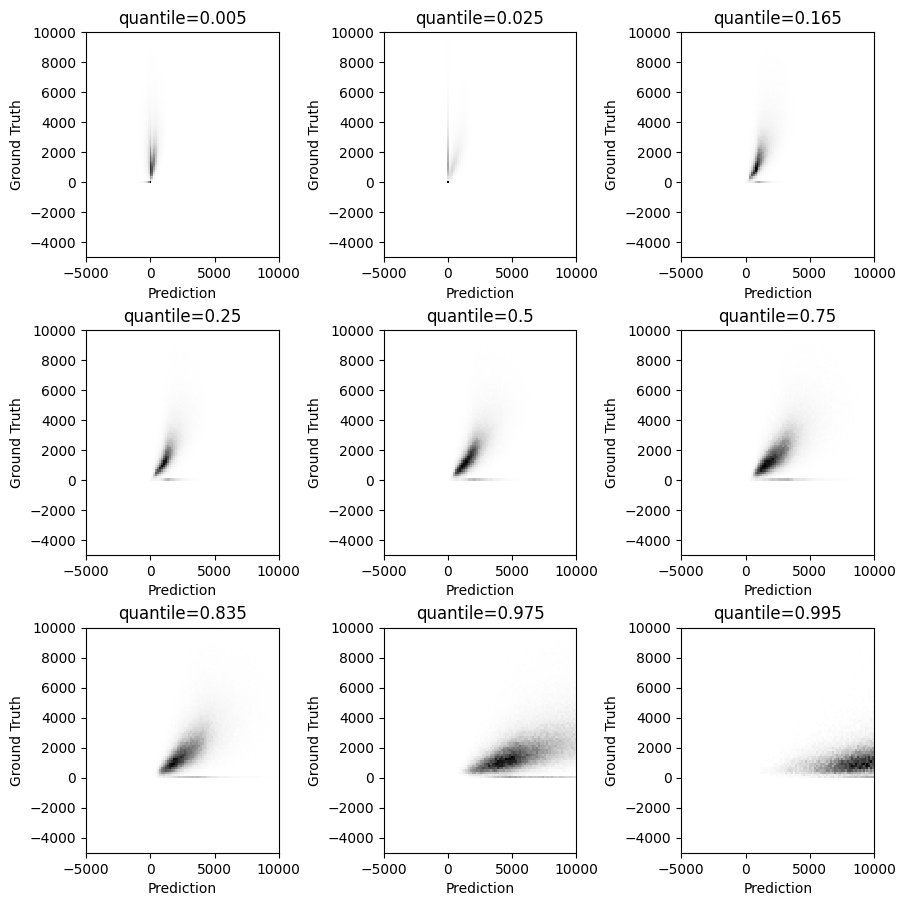

In [413]:
train_df, test_df = loadData()
Xy_train, Xy_valid, X_test, y_test, weights_test, dataDict = setupDMatrix(train_df, test_df)
[eng_train_scores, eng_valid_scores, eng_test_scores] =  evaluate(Xy_train, 
                                                                  Xy_valid, 
                                                                  X_test, 
                                                                  y_test, 
                                                                  weights_test, 
                                                                  'results_xgb_withEngineering', 
                                                                  getAllScores = True, 
                                                                  dataDict = dataDict)


### Evaluation baseline on test set for model trained on raw data

Overall score: 367.18218762665333


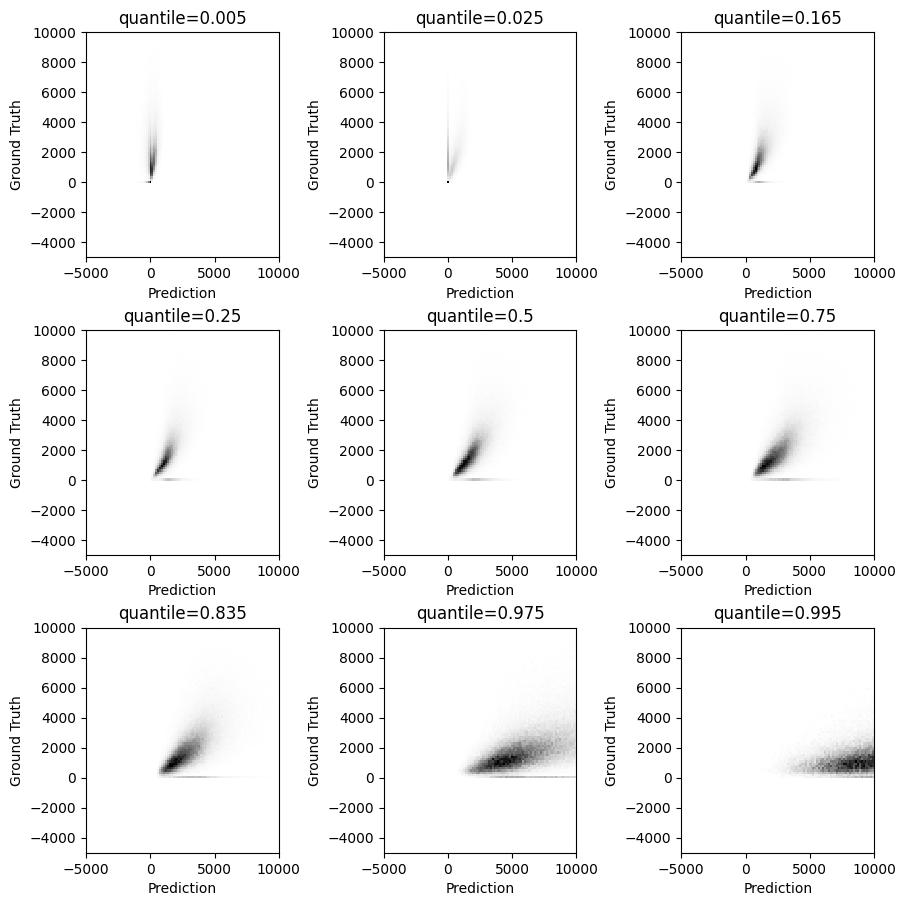

In [414]:
train_df, test_df = loadData(raw=True)
Xy_train, Xy_valid, X_test, y_test, weights_test, dataDict = setupDMatrix(train_df, test_df)
[raw_train_scores, raw_valid_scores, raw_test_scores] =  evaluate(Xy_train, 
                                                                  Xy_valid, 
                                                                  X_test, 
                                                                  y_test, 
                                                                  weights_test, 
                                                                  'results_xgb_raw', 
                                                                  getAllScores = True, 
                                                                  dataDict = dataDict)


In [422]:
results_df = pd.DataFrame(data={'dataset':['engineered','raw'],
                                'train':[eng_train_scores, raw_train_scores],
                                'valid':[eng_valid_scores, raw_valid_scores],
                                'test': [eng_test_scores, raw_test_scores]})
results_df.head()

,dataset,train,valid,test
0,engineered,287.260307,370.000177,369.346077
1,raw,289.561714,368.163468,367.182188


Test set pinball scores from engineered dataset are worse (statistical significance unclear, but there doesnt appear to be an improvement)!
Training set scores indicate both models seem to overfit, but problem seems worse with the dataset with engineered/augmented features.

Across both datasets, cursory examination of hyperparameters explored and ulitmately settled on by hyperopt suggests that there was scope for stronger regularization, but validation performance was worse when regularization was higher. 

So for now, will have to live with the overfits.

Let's try to see if the augmented/engineered features even help.

# Recursive Feature Elimination

Applying recursive feature elimination to see if there is any improvement.
This will be based on the xgb feature importance scores.
It will also let us look at the feature importances to see how valuable the augmented/engineered features are.

In [10]:
def createQDMatrices(train_df, columns):
    randomState = 0
    rng = np.random.RandomState(randomState)
    y = train_df['expense']
    X = train_df[columns]#test_df.columns]
    weights = train_df['wi']
    X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, 
                                                                                     y, 
                                                                                     weights, 
                                                                                     test_size=0.3, 
                                                                                     random_state=randomState)

    X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(X_train, 
                                                                                        y_train, 
                                                                                        weights_train, 
                                                                                        test_size=0.15, 
                                                                                        random_state=randomState)

    # We will be using the `hist` tree method, quantile DMatrix can be used to preserve
    # memory.
    # Do not use the `exact` tree method for quantile regression, otherwise the
    # performance might drop.
    Xy_train = xgb.QuantileDMatrix(X_train, y_train, weight = weights_train, enable_categorical=True)
    # use Xy_train as a reference
    Xy_valid = xgb.QuantileDMatrix(X_valid, y_valid, weight = weights_valid, ref=Xy_train, enable_categorical=True)
    # use Xy_train as a reference
#     Xy_test = xgb.QuantileDMatrix(X_test, y_test, weight = weights_test, ref=Xy_train, enable_categorical=True)
    return Xy_train, Xy_valid, X_valid, y_valid, weights_valid


def trainBooster(Xy_train, Xy_valid, X_valid, y_valid, weights_valid, c):
    qs = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
    q = qs[c]

    savePath = 'results_xgb_withEngineering'
    sName = os.path.join(savePath, 'HistGBR_meta_'+str(q).replace('.','_')+'.pickle')

    with open(sName, 'rb') as handle:
        best_hyperparams = pickle.load(handle)
    
    evals_result = {}
    booster = xgb.train(
        {
            # Use the quantile objective function.
            'objective': 'reg:quantileerror',
            'tree_method': 'hist',
            'quantile_alpha': q,
            # Let's try not to overfit.
            'learning_rate': best_hyperparams['learning_rate'],
            'max_depth': int(best_hyperparams['max_depth']),
            'seed': randomState,
            'nthread' : 6,
            'max_cat_to_onehot': 10,
            'gamma': best_hyperparams['gamma'],
            'alpha': best_hyperparams['alpha'],
            'lambda': best_hyperparams['lambda'],
            'subsample': best_hyperparams['subsample'],
            'colsample_bytree': best_hyperparams['colsample_bytree'],
            'min_child_weight': best_hyperparams['min_child_weight']

        },
        Xy_train,
        num_boost_round=int(best_hyperparams['num_boost_round']),
        early_stopping_rounds=30,
        # The evaluation result is a weighted average across multiple quantiles.
        evals=[(Xy_train, 'train'), (Xy_valid, 'eval')],
        evals_result=evals_result,
        verbose_eval=False)

    scores = booster.inplace_predict(X_valid)
    m = mean_pinball_loss(y_valid, scores, sample_weight=weights_valid, alpha=q)

    return m, booster


train_df = pd.read_csv(os.path.join(path, 'train_augmented_engineered.csv'),
                       header = 0,
                       index_col='id')
test_df = pd.read_csv(os.path.join(path, 'test_augmented_engineered.csv'),
                      header = 0,
                      index_col='id')
allCols = list(test_df.columns)

rfeResults = dict()
for c in range(9):
    # Initialization
    n_features = len(allCols)
    n_features_to_select = n_features // 2

    step = 1

    support = np.ones(n_features, dtype=bool)
    ranking = np.ones(n_features, dtype=int)

    losses = []
    removed = []
    scoreList = []
    allCols = np.array(allCols)

    qResults = dict()
    # Elimination
    while np.sum(support) > n_features_to_select:
        # Remaining features
        features = np.arange(n_features)[support]

        # Rank the remaining features
        Xy_train, Xy_valid, X_valid, y_valid, weights_valid = createQDMatrices(train_df, allCols[features])
        loss, booster = trainBooster(Xy_train, Xy_valid, X_valid, y_valid, weights_valid, c)

        # Get importance and rank them
        scores = booster.get_fscore()
#         print('Scores: ')
#         print(scores)
        scoreList.append(scores)
        importances = []
        for col in allCols[features]:
            importances.append(scores[col])
        ranks = np.argsort(importances)

        # Eliminate the worse features
        threshold = step

        # Compute step score on the previous selection iteration
        # because 'estimator' must use features
        # that have not been eliminated yet
        losses.append(loss)
        removed.append(allCols[features[ranks][:threshold]])
#         print(f'Removing : {removed[-1]}')
        support[features[ranks][:threshold]] = False
        ranking[np.logical_not(support)] += 1

    # Set final attributes
    features = np.arange(n_features)[support]
    Xy_train, Xy_valid, X_valid, y_valid, weights_valid = createQDMatrices(train_df, allCols[features])
    loss, booster = trainBooster(Xy_train, Xy_valid, X_valid, y_valid, weights_valid, c)
    scores = booster.get_fscore()
#         print('Scores: ')
#         print(scores)
    scoreList.append(scores)
    # Compute step score when only n_features_to_select features left
    losses.append(loss)
    qResults['scores'] = scoreList
    qResults['losses'] = losses
    qResults['removed'] = removed    
    qResults['selected'] = allCols[features]
    print(f'Finished {c}: removed {removed}')
    rfeResults[c] = qResults
    
    


KeyboardInterrupt



In [352]:
removalCnt = dict()
removalStep = dict()
for qi in range(9):
    for c, r in enumerate(rfeResults[qi]['removed']):
        if r[0] in removalCnt:
            removalCnt[r[0]] += 1
            removalStep[r[0]].append(c)
        else:
            removalCnt[r[0]] = 1
            removalStep[r[0]] = [c]
            
removal_df = pd.DataFrame(data={'col':removalCnt.keys(),'removalCnt':removalCnt.values()})
sorted_removal_df = removal_df.sort_values(by=['removalCnt'], ascending=False)
sorted_removal_df.head(30)

,col,removalCnt
0,occupation_q4,9
6,occupation_q5,9
1,occupation_q3,9
12,state_q4,9
8,marital,9
7,familysize,9
17,state_q3,9
4,occupation_q2,9
3,educationCat,9
2,urban,9


Seems like the features prioritized for elimination by RFE for models at all/most quantiles are the engineered/augmented ones :(

Digging a little deeper ...

#### Importance scores (scaled  to max 1) for worst features 

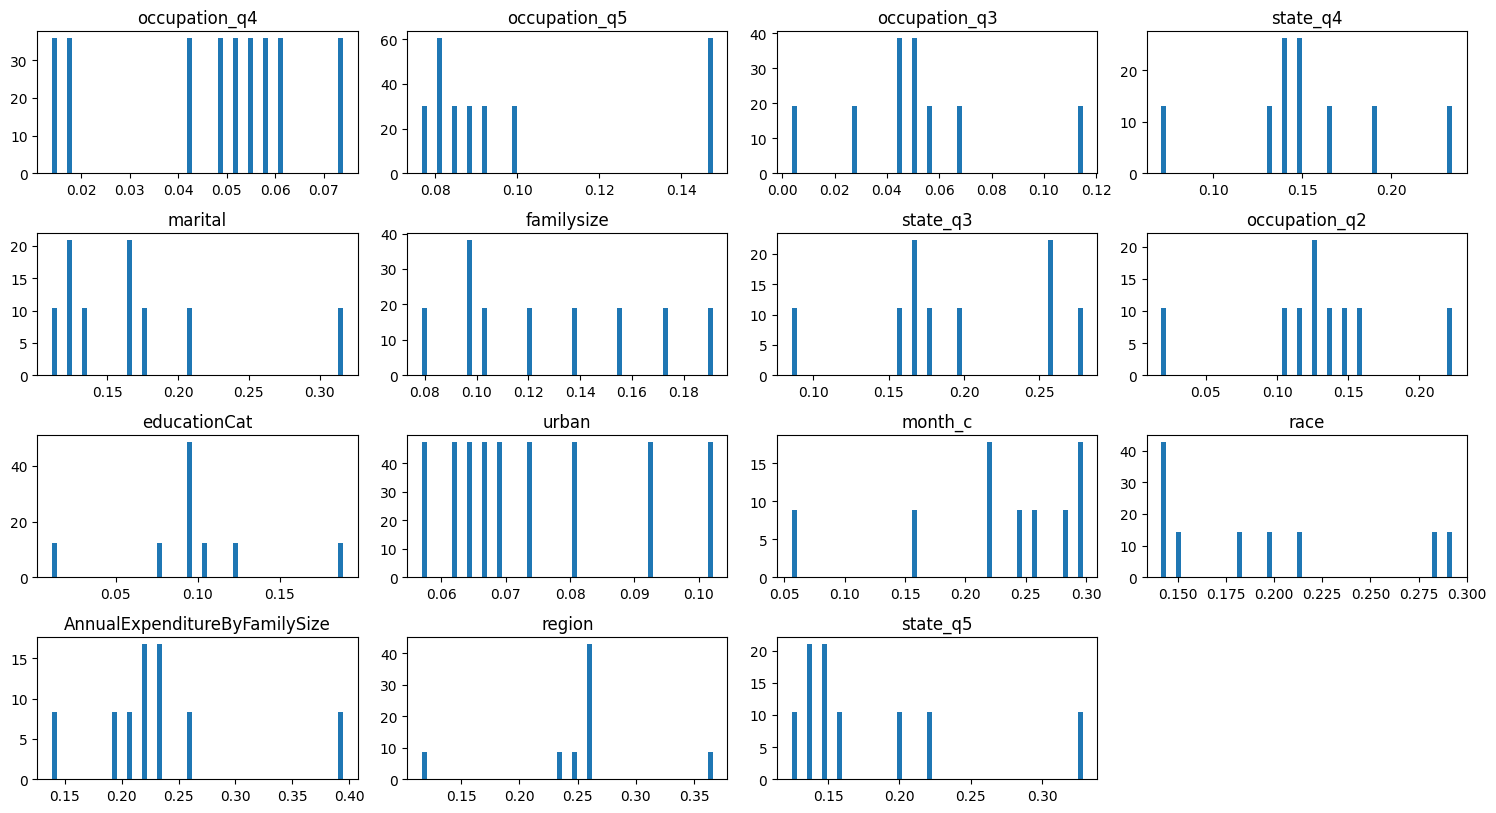

In [383]:
markForRemoval = sorted_removal_df.iloc[:,0].values[:15].tolist()
plt.figure(figsize=(15,10))
for i, rCol in enumerate(markForRemoval):
    plt.subplot(5,4,i+1)
    score = []
    for qi in range(9):
        score.append(rfeResults[qi]['scores'][0][rCol]/np.max(list(rfeResults[qi]['scores'][0].values())))
    
    a_heights, a_bins = np.histogram(score, bins=20, density=True)
    width = (a_bins[1] - a_bins[0])/3
    plt.bar(a_bins[:-1], a_heights, width=width)

    plt.title(rCol)
    
plt.tight_layout(pad=1.0)
        

#### ... compared to other features

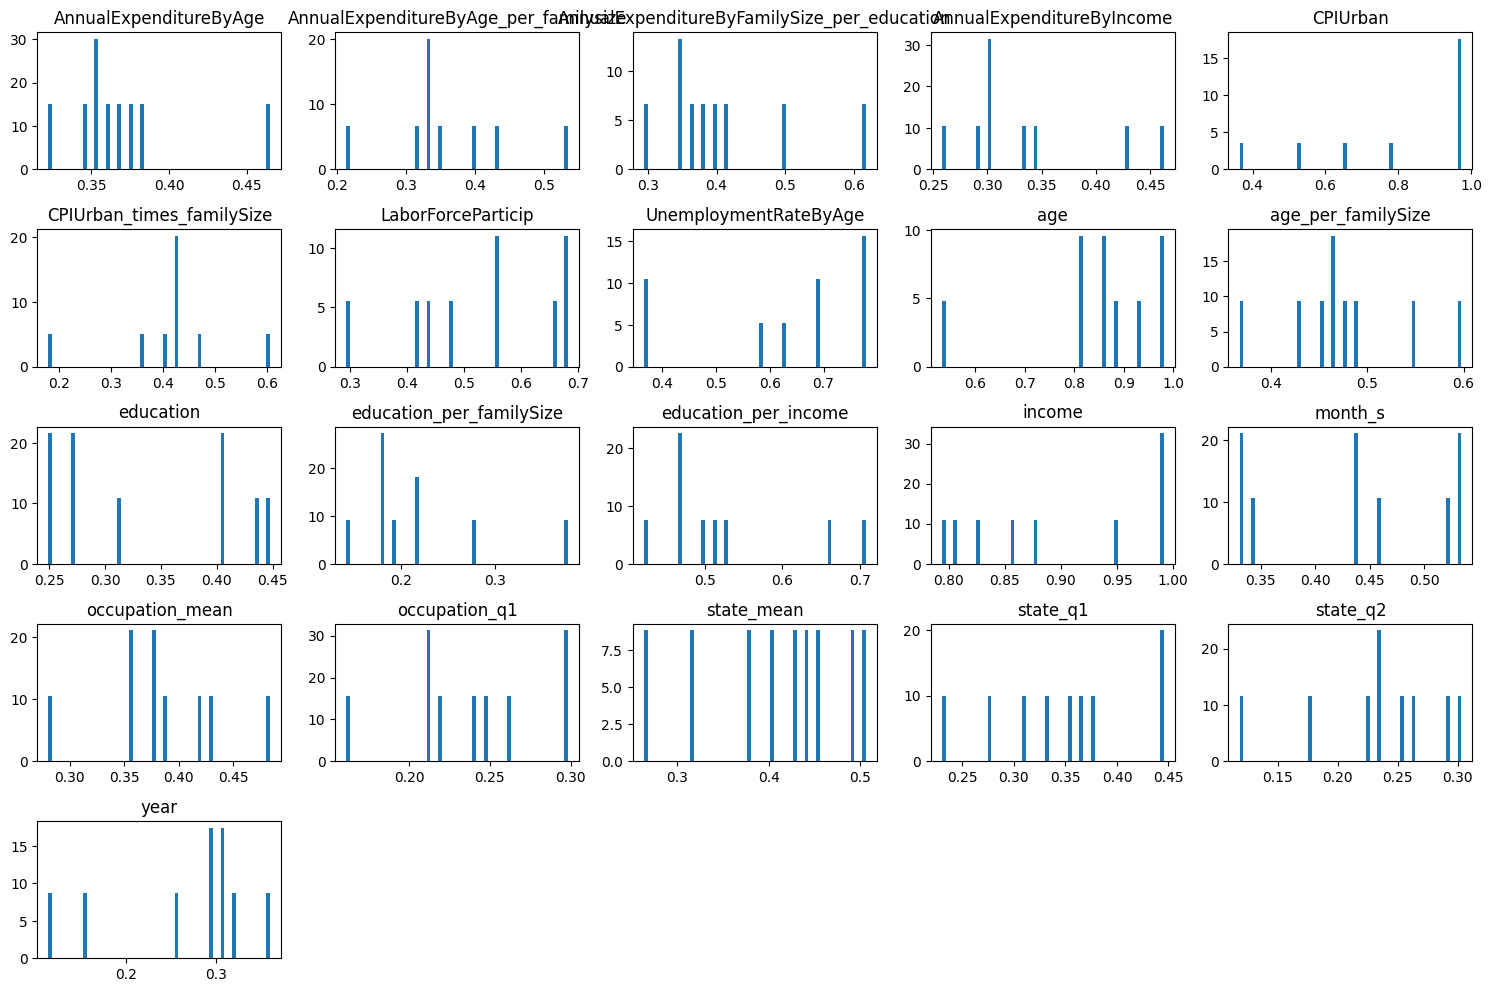

In [386]:
plt.figure(figsize=(15,10))
for i, col in enumerate(np.setdiff1d(allCols, markForRemoval)):
    plt.subplot(5,5,i+1)
    score = []
    for qi in range(9):
        score.append(rfeResults[qi]['scores'][0][col]/np.max(list(rfeResults[qi]['scores'][0].values())))
    
    a_heights, a_bins = np.histogram(score, bins=20, density=True)
    width = (a_bins[1] - a_bins[0])/3
    plt.bar(a_bins[:-1], a_heights, width=width)

    plt.title(col)
    
plt.tight_layout(pad=1.0)
        

Clearly the features most often marked for removal are the worst.

In [421]:
#### From the perspective of how feature removal affected training loss

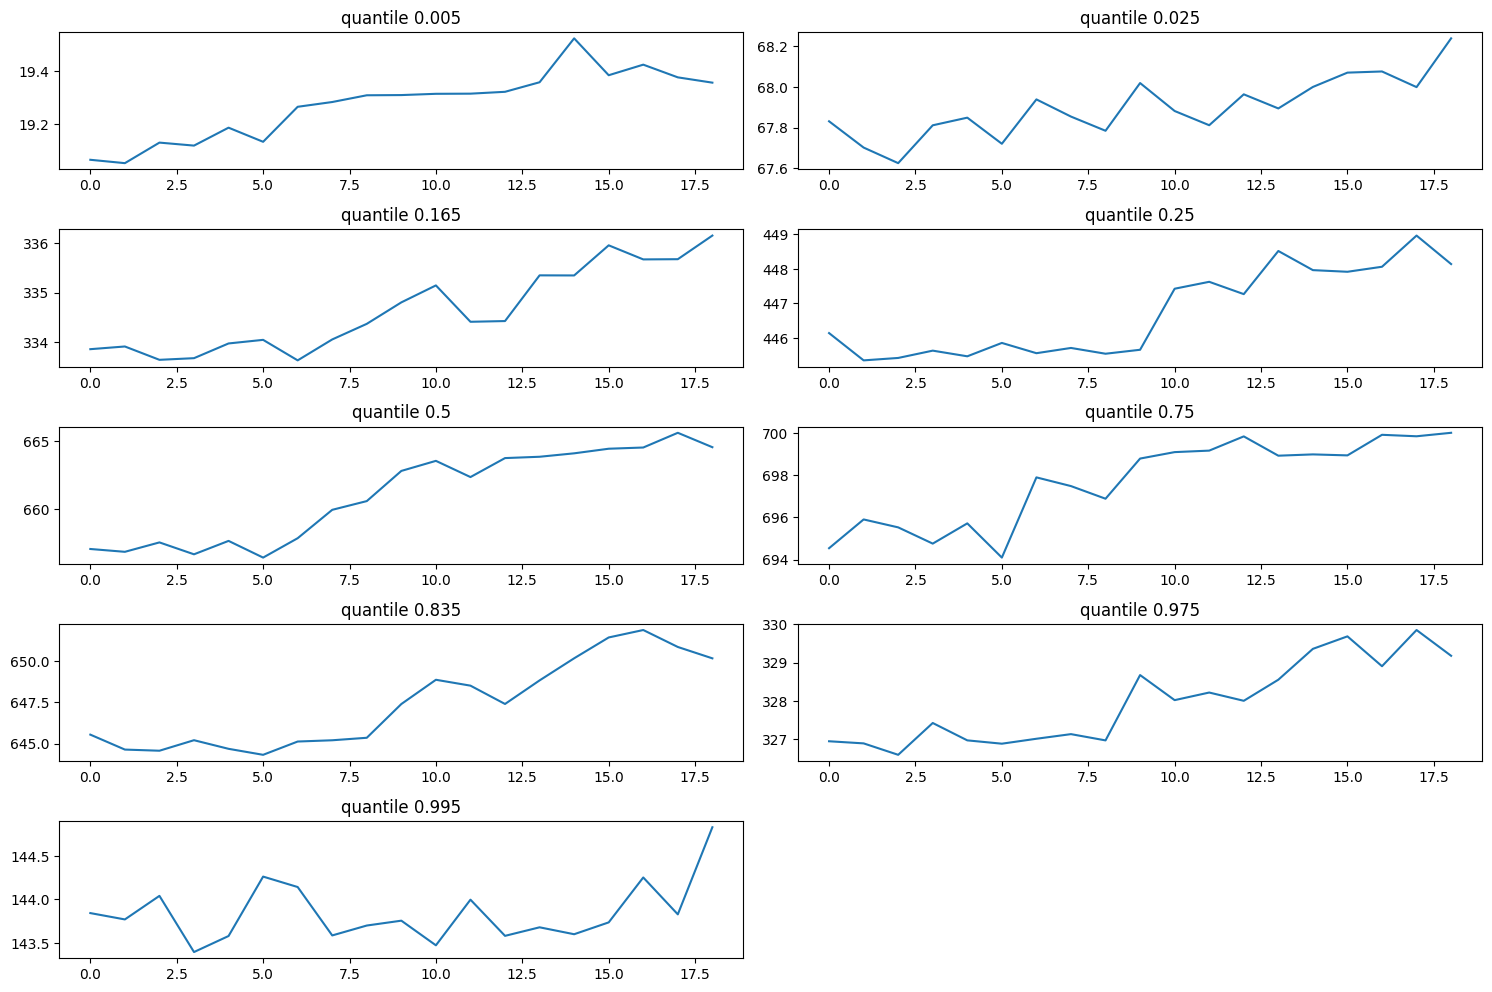

In [390]:
plt.figure(figsize=(15,10))
qs = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
for qi in range(9):
    plt.subplot(5,2,qi+1)
    plt.plot(rfeResults[qi]['losses'])

    plt.title(f'quantile {qs[qi]}')
    
plt.tight_layout(pad=1.0)
        

Removing the features increases training loss, but this may not be a bad sign ... 

Rerunning hyperparameter optimization after removing the worst offenders does not improve test set performance by much, but in hindsight, this should have been expected. Their importance scores were low to begin with. 

It is possible that an additive approach (RFA) may have produced better results. 

#### One more effort to improve performance

Looking at the selected hyperparameters, it appears that the maximum depth had hit the upper bound set for the hyperparameter search for the harder quantiles (0.5, 0.75).

Increasing this depth improved performance on the raw dataset, but not on the augmented/engineered dataset.

Overall score: 366.734887821563


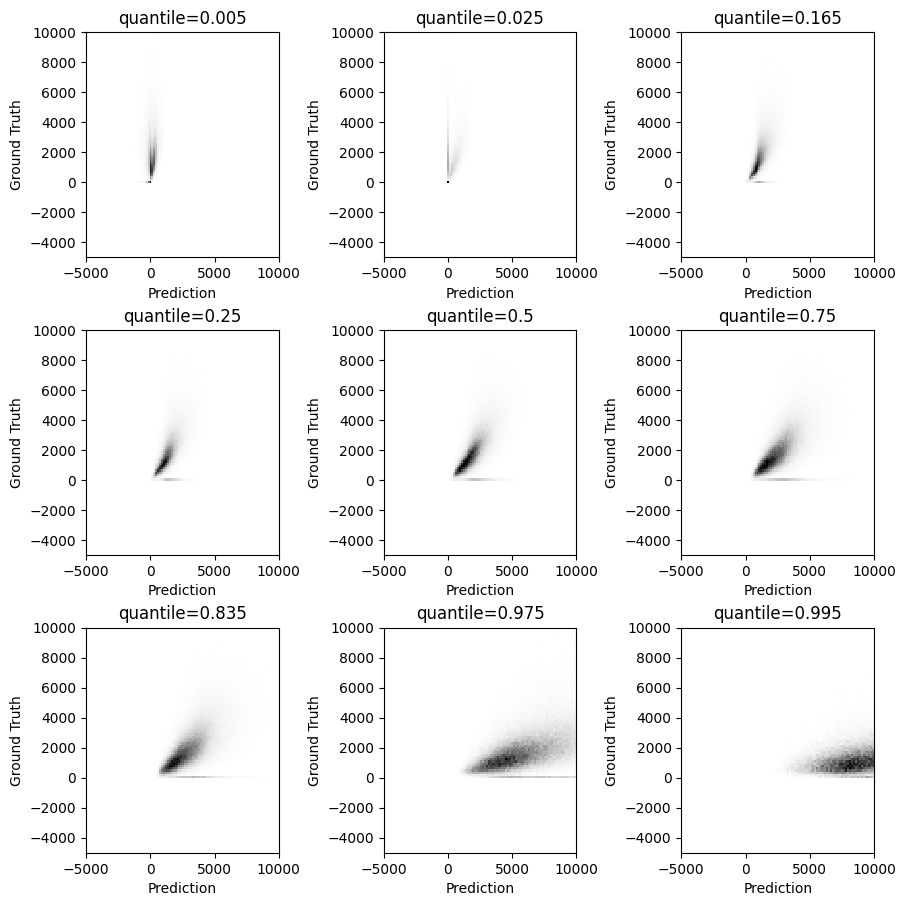

In [36]:
train_df, test_df = loadData(raw=True)
Xy_train, Xy_valid, X_test, y_test, weights_test, dataDict = setupDMatrix(train_df, test_df)
[raw_train_scores2, raw_valid_scores2, raw_test_scores2] =  evaluate(Xy_train, 
                                                                  Xy_valid, 
                                                                  X_test, 
                                                                  y_test, 
                                                                  weights_test, 
                                                                  'results_xgb_raw_deeper', 
                                                                  getAllScores = True, 
                                                                  dataDict = dataDict)


In [419]:
results_df = pd.DataFrame(data={'dataset':['engineered','raw','raw_deeper'],
                                'train':[eng_train_scores, raw_train_scores, raw_train_scores2],
                                'valid':[eng_valid_scores, raw_valid_scores, raw_valid_scores2],
                                'test': [eng_test_scores, raw_test_scores, raw_test_scores2]})
results_df.head()

,dataset,train,valid,test
0,engineered,287.260307,370.000177,369.346077
1,raw,289.561714,368.163468,367.182188
2,raw_deeper,268.068332,368.000850,366.734888


## Assessing sensitivity of selected XGB solution to seeds

In [37]:
def evaluate2(Xy_train, Xy_valid, X_test, y_test, weights_test, hyperParamPath, dataDict = None):
    testPinScores = np.zeros((9,10)) 
    testQs = np.zeros((9,10))
    validPinScores = np.zeros((9,10))
    validQs = np.zeros((9,10))
    for seed in range(10):
        for c, q in enumerate([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):

            sName = os.path.join(hyperParamPath, 'HistGBR_meta_'+str(q).replace('.','_')+'.pickle')

            with open(sName, 'rb') as handle:
                best_hyperparams = pickle.load(handle)

            booster = xgb.train(
                {
                    # Use the quantile objective function.
                    'objective': 'reg:quantileerror',
                    'tree_method': 'hist',
                    'quantile_alpha': q,
                    # Let's try not to overfit.
                    'learning_rate': best_hyperparams['learning_rate'],
                    'max_depth': int(best_hyperparams['max_depth']),
                    'seed': seed,
                    'nthread' : 6,
                    'max_cat_to_onehot': 10,
                    'gamma': best_hyperparams['gamma'],
                    'alpha': best_hyperparams['alpha'],
                    'lambda': best_hyperparams['lambda'],
                    'subsample': best_hyperparams['subsample'],
                    'colsample_bytree': best_hyperparams['colsample_bytree'],
                    'min_child_weight': best_hyperparams['min_child_weight']

                },
                Xy_train,
                num_boost_round=int(best_hyperparams['num_boost_round']),
                early_stopping_rounds=30,
                # The evaluation result is a weighted average across multiple quantiles.
                evals=[(Xy_train, 'train'), (Xy_valid, 'eval')],
                evals_result=evals_result,
                verbose_eval=False)

            scores = booster.inplace_predict(X_test)
            m = mean_pinball_loss(y_test, scores, sample_weight=weights_test, alpha=q)
            testPinScores[c,seed] = m
            testQs[c,seed] = np.mean(y_test <= scores)

            scores = booster.inplace_predict(dataDict['valid'][0])
            m = mean_pinball_loss(dataDict['valid'][1], scores, sample_weight=dataDict['valid'][2], alpha=q)
            validPinScores[c,seed] = m
            testQs[c,seed] = np.mean(dataDict['valid'][1] <= scores)

    return [testPinScores, testQs, validPinScores, validQs]


In [ ]:
train_df, test_df = loadData(raw=True)
Xy_train, Xy_valid, X_test, y_test, weights_test, dataDict = setupDMatrix(train_df, test_df)
[testPinScores, testQs, validPinScores, validQs] =  evaluate2(Xy_train, 
                                                              Xy_valid, 
                                                              X_test, 
                                                              y_test, 
                                                              weights_test, 
                                                              'results_xgb_raw_deeper', 
                                                              dataDict = dataDict)

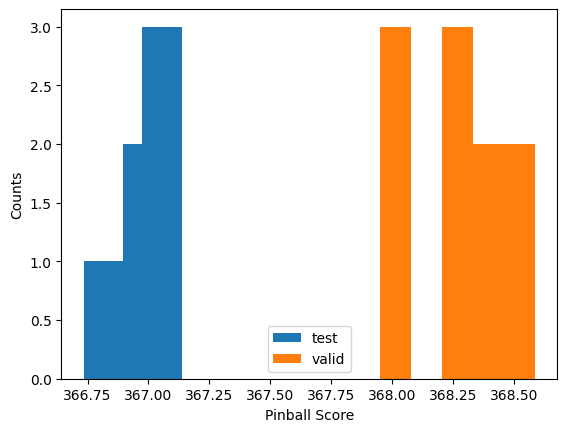

In [436]:
plt.hist(np.mean(testPinScores, axis=0), bins = 6, rwidth=0.25, alpha=0.5, label='test')
plt.hist(np.mean(validPinScores, axis=0), bins = 5, rwidth=0.25, alpha=0.5, label='valid')
plt.xlabel('Pinball Score')
plt.ylabel('Counts')
plt.legend()

* Results show that the distribution is quite narrow and the hyperparameters produce reliably good fits across seeds.
* They also suggest that the improvement over models fit to the raw dataset at lower max depth may not be significant.
* Choosing the best seed from these results (in terms of test set performance) for final prediction.


In [39]:
bestSeed = np.argmin(np.mean(testPinScores, axis=0))

boosters = []
qs = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
randomState = 0
for c, q in enumerate(qs):
    savePath = 'results_xgb_raw_deeper'
    sName = os.path.join(savePath, 'HistGBR_meta_'+str(q).replace('.','_')+'.pickle')

    with open(sName, 'rb') as handle:
        best_hyperparams = pickle.load(handle)

    evals_result = {}
    booster = xgb.train(
        {
            # Use the quantile objective function.
            'objective': 'reg:quantileerror',
            'tree_method': 'hist',
            'quantile_alpha': q,
            # Let's try not to overfit.
            'learning_rate': best_hyperparams['learning_rate'],
            'max_depth': int(best_hyperparams['max_depth']),
            'seed': bestSeed,
            'nthread' : 6,
            'max_cat_to_onehot': 10,
            'gamma': best_hyperparams['gamma'],
            'alpha': best_hyperparams['alpha'],
            'lambda': best_hyperparams['lambda'],
            'subsample': best_hyperparams['subsample'],
            'colsample_bytree': best_hyperparams['colsample_bytree'],
            'min_child_weight': best_hyperparams['min_child_weight']

        },
        Xy_train,
        num_boost_round=int(best_hyperparams['num_boost_round']),
        early_stopping_rounds=30,
        # The evaluation result is a weighted average across multiple quantiles.
        evals=[(Xy_train, 'train'), (Xy_valid, 'eval')],
        evals_result=evals_result,
        verbose_eval=False)

    boosters.append(booster)

In [40]:
true_testset = test_df.reset_index().to_numpy()
results = np.zeros((true_testset.shape[0],10))
results[:,0] = true_testset[:,0]
for c, q in enumerate(qs):
    results[:,c+1] = boosters[c].inplace_predict(true_testset[:,1:])


In [41]:
results_df = pd.DataFrame(data=results, columns=['id','q1','q2','q3','q4','q5','q6','q7','q8','q9'])
results_df['id'] = results_df['id'].astype(int)

In [452]:
results_df.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,741875,75.039299,186.655060,709.166138,918.169312,1345.916382,1803.459961,2241.901855,3707.224854,13443.130859
1,741876,-0.959936,79.773491,1611.793213,2161.547363,2812.984375,3853.611328,3939.575684,9629.208008,19358.359375
2,741877,12.705339,50.722237,531.870178,695.726868,829.529602,1358.263184,1532.397583,4924.454102,11130.778320
3,741878,7.067867,16.649946,675.022034,1040.132568,1748.586426,2442.638428,2724.981689,6649.074219,15287.879883
4,741879,-189.997070,7.059158,1224.785156,1470.622803,2988.477295,2352.124023,3822.526855,9996.137695,16516.501953


In [43]:
results_df.to_csv(path_or_buf=os.path.join('finalResults', 'results_xgb.csv'), index=False)

### Evaluating feature importance

Text(0.5, 1.05, 'Gain')

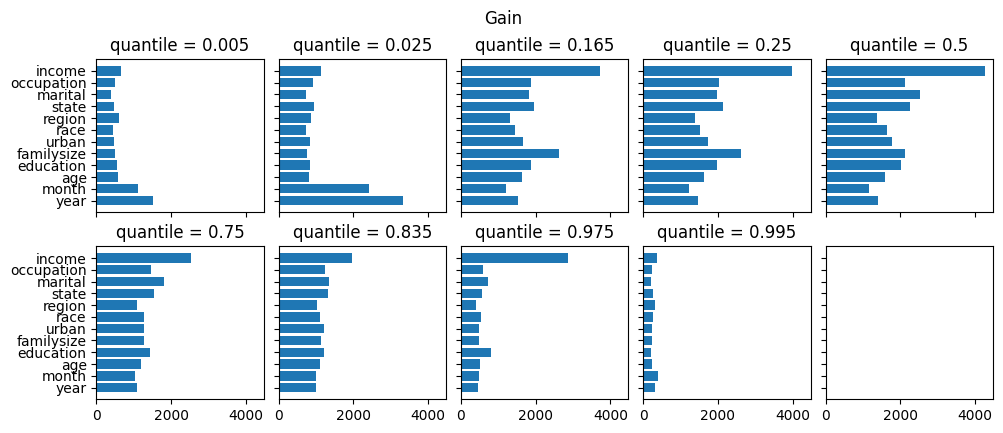

In [52]:
f, axs = plt.subplots(2, 5,  figsize=(10,4), sharey=True, sharex=True)
for c, q in enumerate([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):
    ax_yind = c%5
    ax_xind = c//5
    scores = boosters[c].get_score(importance_type='gain')

    y_pos = np.arange(len(scores.keys()))
    axs[ax_xind, ax_yind].barh(y_pos, scores.values(), align='center')
    axs[ax_xind, ax_yind].set_yticks(y_pos, labels=scores.keys())
    axs[ax_xind, ax_yind].set_title(f'quantile = {q}')
plt.tight_layout(pad=0.5)    
plt.suptitle('Gain', x= 0.5,y=1.05)

Text(0.5, 1.05, 'Frequency')

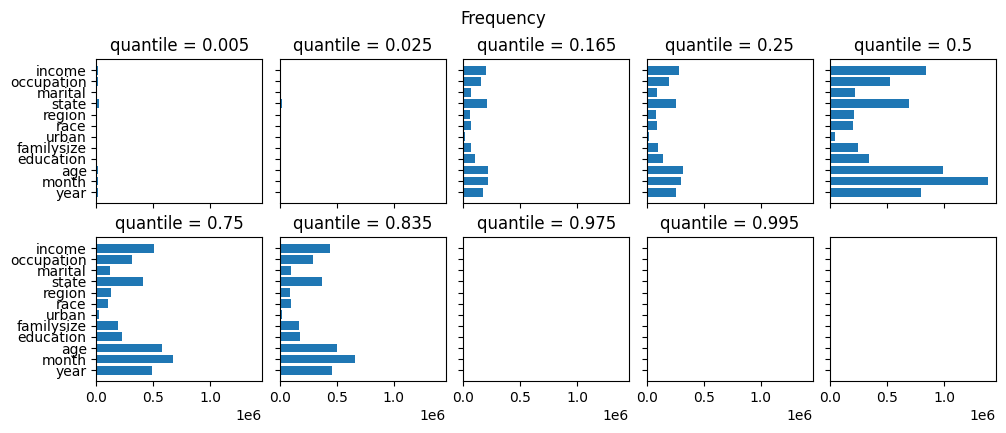

In [54]:
f, axs = plt.subplots(2, 5,  figsize=(10,4), sharey=True, sharex=True)
for c, q in enumerate([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):
    ax_yind = c%5
    ax_xind = c//5
    scores = boosters[c].get_score(importance_type='weight')

    y_pos = np.arange(len(scores.keys()))
    axs[ax_xind, ax_yind].barh(y_pos, scores.values(), align='center')
    axs[ax_xind, ax_yind].set_yticks(y_pos, labels=scores.keys())
    axs[ax_xind, ax_yind].set_title(f'quantile = {q}')
plt.tight_layout(pad=0.5)    
plt.suptitle('Frequency', x= 0.5,y=1.05)

Text(0.5, 1.05, 'Frequency')

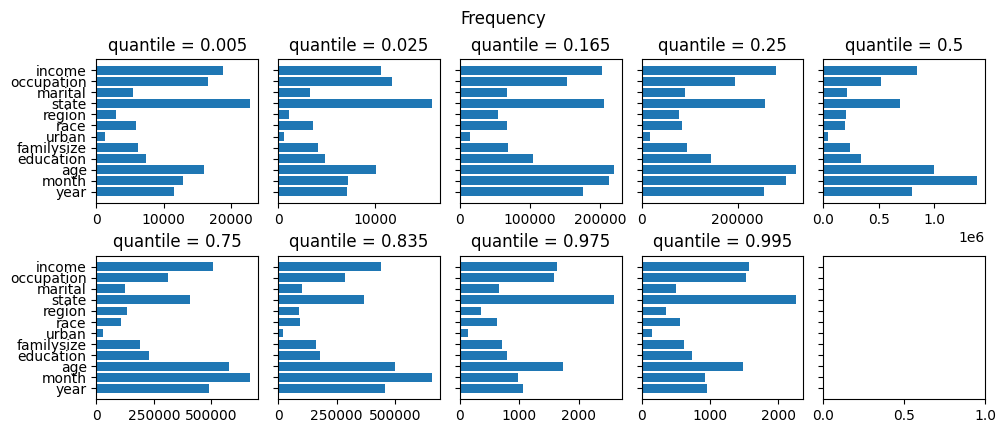

In [55]:
f, axs = plt.subplots(2, 5,  figsize=(10,4), sharey=True)
for c, q in enumerate([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):
    ax_yind = c%5
    ax_xind = c//5
    scores = boosters[c].get_score(importance_type='weight')

    y_pos = np.arange(len(scores.keys()))
    axs[ax_xind, ax_yind].barh(y_pos, scores.values(), align='center')
    axs[ax_xind, ax_yind].set_yticks(y_pos, labels=scores.keys())
    axs[ax_xind, ax_yind].set_title(f'quantile = {q}')
plt.tight_layout(pad=0.5)    
plt.suptitle('Frequency', x= 0.5,y=1.05)

Feature importance evaluated by gain shows:
* The extreme quantiles rely more on the month and year.
* All other quantiles rely heavily on income, as expected, particularly from the brief provided.
* Other important features, particularly in the more challenging middle quantiles, are family size, occupation, marital status, education and state.

Feature importance evaluated by frequency shows:
* Harder quantiles require deeper trees (high frequency across all features)
* Urban and, to some extent, region seem less important
* While marital status does contributed strongly to the gain, it is used less frequently.